# Experiment Analysis - Jupyter Notebook

## Handeln

#### Intro

The first few weeks of the seminar are used to get into the idea of motor control. A good way to learn is also to experience the stimuli and action in the field of human perception and action. Therefore, the first weeks are focussed on doing a simple pointing task in different conditions, very losely based on Fitts' paper from the 1950's.

Fitts, P.M. (1954). The Information Capacity of the Human Motor System in Controlling the Amplitude of Movement. Journal of Experimental Psychology, 47(6), 381-391.

Fitts' observed that moving horizontally between two targets depended on the width of the targets and the distance between them. Fitts only looked at one-dimensional movements. In the experiment for the Handeln course we will explore how 2D-movements might depend on such parameters as e.g. target shape. More particularly we will investigate if the movements will remain straight movements to the centre of the target or not. For this we will need to analyse the trajectories of the movements depending on target shape and any other parameters of interest in the experiment.

#### Requirements before starting to work in this notebook

In this notebook we will be looking at the analysis of movement data. **Before starting to work on this notebook you should have:** 
- installed the required conda environment
- run the little experiment on yourself (best using a graphics tablet or computer mouse, but failing that a track pad), as you will be working on your own data.

Do let us know if you have trouble running the experiment. We can then have a look at why this might be so (sometimes different systems respond differently to the same code), and in the worst case we can provide you with a default dataset to work on.

#### About the data

The data for the experiment should be stored in a folder called `data`. In this notebook we will be taking a look at the data and investigate whether the different conditions led to different movement trajectories.

Note: It is important to realise that using a computer mouse in the experiment has its caveats. For instance how much a cursor moves across a computer screen does not depend in a one-to-one fashion on how far the mouse is moved in physical space, but also on the speed with which the physical mouse is moved. You can try this out for yourself:  
- mark a begin and end point of your movement in physical space (e.g. put 2 pieces of tape on your desk).
- make sure that the cursor has enough space on the screen to move (e.g. if you are planning to move from left to right, place the cursor on the left end of the screen).
- then move slowly from the beginning marker to the end marker in physical phase and check how much the cursor moved on the screen (this will be a relatively small amount).
- repeat the above two steps but now make a fast movement from beginning to end marker, end again check the distance traveled by the cursor on the screen (this should now have moved to a much larger extent).  

Knowing this it should be evident that in the literature, when it comes to the study of visuomotor control, it is hardly ever the case that computer mouses are used in the experimental task. At the very least this is something to be aware of when planning actual experiments. For the purpose of this course we will however be largely ignoring this, but just so you know that some of the results, particularly for this demo experiment, might have to be taken with a grain of salt.

### Imports
We'll start by loading the most useful packages:
- Numpy: for processing the data (see [here](https://numpy.org/doc/stable/reference/index.html) for documentation / more information)
- Pandas: to read in the data for a given trial (see [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html) for documentation / more information)
- Matplotlib: to make some plots (see [here](https://matplotlib.org/) for documentation / more information)

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import os # for interacting with the operating system (get file names etc)
# import re # for using socalled regular expressions
import Analysis_helper_functions as helpers

# 1. Reading in data

## 1.1. We will start with reading in a single data file

If you have read the readme document that comes with the experiment you will have seen that the data-files consists of two parts:
- one very short part with its own header specifying the condition for that trial
- a second longer part with its own header where the information about the movement trajectory for that trial was stored.

The code below reads in both parts for a single trial.

In [187]:
# -----------------------------------------------------------
# Specify the dataset and trial to read in.
# -----------------------------------------------------------

participant_id = 'max' # note this should be the name you have entered in the pop-up window when you ran the experiment
trial_nr = 2

# directory in which the data for this participant is stored
participant_data_dir = os.path.join("02_Experiment_Code", 'data', str(participant_id)) # note this may be stored in a different folder on your computer. Adjust if necessary.

# -----------------------------------------------------------
# below some code for reading in the data for a single trial
# -----------------------------------------------------------

# let's start with reading in the trial specified above
file_name = 'participant_' + str(participant_id) + '_trial_' + str(trial_nr) + '_trajectory.csv'
file_path = os.path.join(participant_data_dir, file_name)

# Read in HEADER: get first part of the trial to read in the trial conditions
trial_con = pd.read_csv(file_path, nrows = 1)

# Read in BODY:
# we will first read in the whole trajectory. For this part the header index is 2 and everything below it is the data
# we can read it in such that it takes just that part.
trial_data = pd.read_csv(file_path, header = 2)

# ----------------------------------------------
# print the trial conditions for an overview
# ----------------------------------------------
print('------- trial conditions ------------\n')
print(f"target location: \t ({trial_con.loc[0,'target_X']}, {trial_con.loc[0,'target_Y']})")
print(f"cursor size: \t\t ({trial_con.loc[0,'cursor_SX']}, {trial_con.loc[0,'cursor_SY']})")
print(f"starting point location: ({trial_con.loc[0,'start_X']}, {trial_con.loc[0,'start_Y']})")
print(f"shift: ({trial_con.loc[0,'cursor_shift']})")

------- trial conditions ------------

target location: 	 (0, 240)
cursor size: 		 (50, 200)
starting point location: (0, -240)
shift: (240)


#### Concatenating trial meta information and trial data
To be able to better compare between *conditions* later, we need to combine the trial condition information (in ``trial_con``) with the trial data (in `trial_data`).

Let's first have a look at the datasets:

In [188]:
display(trial_con)

display(trial_data.head(3))

,index,start_X,start_Y,startradius,target_X,target_Y,target_SX,target_SY,nDotsTarget,cursor_SX,cursor_SY,nDotsCursor,cursor_shift,shift_threshold,trial_score
0,2,0,-240,10,0,240,10,10,1,50,200,200,240,-240,73


,time,frame_nr,cursor_x,cursor_y,shift_applied
0,0.000370,1,0.0,-241.0,0
1,0.010378,2,0.0,-241.0,0
2,0.015012,3,0.0,-241.0,0


Because they have no columns in common, we cannot use `pd.merge`, but can either use `pd.concat` (and then fill the introduced NANs) or insert each column of `trial_con` seperately into `trial_data`.<br>
Let's use the second option. 

You should look up the API definition of these functions on the pandas documentation if they don't make sense to you:
* dataframe.`insert`

Hint: you can only insert a column once, the second time a ValueError is thrown. Reload the data if this happens.

In [189]:
for i in range(len(trial_con.columns)):
    trial_data.insert(i, trial_con.columns[i], trial_con.iloc[0, i])

display(trial_data.head())

,index,start_X,start_Y,startradius,target_X,target_Y,target_SX,target_SY,nDotsTarget,cursor_SX,cursor_SY,nDotsCursor,cursor_shift,shift_threshold,trial_score,time,frame_nr,cursor_x,cursor_y,shift_applied
0,2,0,-240,10,0,240,10,10,1,50,200,200,240,-240,73,0.000370,1,0.0,-241.0,0
1,2,0,-240,10,0,240,10,10,1,50,200,200,240,-240,73,0.010378,2,0.0,-241.0,0
2,2,0,-240,10,0,240,10,10,1,50,200,200,240,-240,73,0.015012,3,0.0,-241.0,0
3,2,0,-240,10,0,240,10,10,1,50,200,200,240,-240,73,0.027369,4,0.0,-241.0,0
4,2,0,-240,10,0,240,10,10,1,50,200,200,240,-240,73,0.031672,5,0.0,-241.0,0


The above can help to obtain one dataframe with the trial condition added to each row in the trajectory data. If you do this for each trial and then concatenate the data for all the trials in a big list, you will then only need to work with one dataframe. 

An alternative is to skip the step above and keep separate dataframes for the trajectory data and the trial conditions, when reading in all the data for a given participant. This might help to have a better overview of the conditions in the experiment as you will have these in a separate list.

In both cases it is however a good idea to add a separate column that stores the trial number that the data corresponds to. 

In [190]:
trial_data['trial'] = trial_nr
display(trial_data.head())

,index,start_X,start_Y,startradius,target_X,target_Y,target_SX,target_SY,nDotsTarget,cursor_SX,...,nDotsCursor,cursor_shift,shift_threshold,trial_score,time,frame_nr,cursor_x,cursor_y,shift_applied,trial
0,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.000370,1,0.0,-241.0,0,2
1,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.010378,2,0.0,-241.0,0,2
2,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.015012,3,0.0,-241.0,0,2
3,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.027369,4,0.0,-241.0,0,2
4,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.031672,5,0.0,-241.0,0,2


## 1.2. Read in all trials of one participant

Hint: The following cells should give you an idea on the steps necessary to tackle this task in a clean manner. <br>
This is however not the only (good) solution. You could for example also write a data loader class. <br>

Rewrite above code to read in one trial as a function. Give it the parameters:
* `data_dir`
* `participant_id`
* `trial_nr`

It should return the data for one trial containing the meta (condition) information (concatenated meta data and trial data).

In [191]:
def readTrial(data_dir, participant_id, trial_nr) -> pd.DataFrame:
    file_name = 'participant_' + str(participant_id) + '_trial_' + str(trial_nr) + '_trajectory.csv'
    file_path = os.path.join(data_dir, file_name)
    trial_con = pd.read_csv(file_path, nrows = 1)
    trial_data = pd.read_csv(file_path, header = 2)

    for i in range(len(trial_con.columns)):
        trial_data.insert(i, trial_con.columns[i], trial_con.iloc[0, i])

    trial_data['trial'] = trial_nr

    return trial_data

Iterate over all files in the `participant_data_dir` folder, load the data for each file, concatenate it into one big pandas dataframe.

Hint:
* For listing all files of a directory, you can use the package `os`
* For concatenating a `list` of single pandas dataframes you can use `pd.concat(list_of_dataframes)`

In [192]:
data_dir = os.path.join("02_Experiment_Code", 'data', str(participant_id))
participant_id = "max"
trial_nr = 2

dataframes = []
for filename in os.listdir(data_dir):
    dataframes.append(readTrial(data_dir, participant_id, trial_nr))

concat_dataframe = pd.concat(dataframes)
display(concat_dataframe)

,index,start_X,start_Y,startradius,target_X,target_Y,target_SX,target_SY,nDotsTarget,cursor_SX,...,nDotsCursor,cursor_shift,shift_threshold,trial_score,time,frame_nr,cursor_x,cursor_y,shift_applied,trial
0,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.000370,1,0.0,-241.0,0,2
1,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.010378,2,0.0,-241.0,0,2
2,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.015012,3,0.0,-241.0,0,2
3,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.027369,4,0.0,-241.0,0,2
4,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,0.031672,5,0.0,-241.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,2.998727,360,-5.0,218.0,1,2
360,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,3.010944,361,-5.0,218.0,1,2
361,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,3.015345,362,-5.0,218.0,1,2
362,2,0,-240,10,0,240,10,10,1,50,...,200,240,-240,73,3.028126,363,-5.0,218.0,1,2


### 1.3. (optional) Read in all data from all participants

If you have multiple participants, e.g. because you ran the experiment multiple times on yourself or have shared data with a friend, you can now try to read in all you data at once.

The logic is quite equivalent to 1.2 above

In [193]:
...

Ellipsis

# 2. Pre-processing data

## 2.1. Calculating velocity

Let us first calculate the velocity based on the cursors position.

For this we will use the `velocity` function defined in the `Analysis_helper_functions` script.

Have a look at the logic behind it:
* What is the formular with which the velocity is calculated? Try noting it down below (replace ...) using the following notation
  * $v$ = velocity (combined velocity in the 2D plane)
  * $p_x$ = x position
  * $p_y$ = y position
  * $dt$ = delta t, time between two samples
  * So with the velocity is calculated in `Analysis_helper_functions` as:   
    $v = ...$

* (optional) Where is that formula coming from? What is the intuition? Can you derive it?

In [194]:
# already add the velocity information straight away for extra convenience with plotting.
velo = helpers.velocity(trial_data,['cursor_x','cursor_y'],'time')
trial_data['vx'] = velo[:,1]
trial_data['vy'] = velo[:,2]
trial_data['vabs'] = velo[:,3]

# Note it can be useful to already immediately build this step when reading in the single trial.
# Can you think of a reason why that would be a good idea?

## 2.2. Outlier detection

One aspect that could make us want to drop a trial is if that trial took waaaaaaaaaay to long (short).

1. How do we define "waaaaaaaaaay to long (short)"?
2. How do we drop trials that took "waaaaaaaaaay to long (short)"?

This is not an easy decision without having a look at the data. To see if there are any very different values you might to plot the movement times of the trials and have a look.

A common procedure is however to compute the mean and the standard deviation of a variable that is to be used for outlier removal: here we will use the movement/trial time. If a particular duration of a trial is more than three standard deviations away from the mean duration, this is indicative that something weird might have happened during that trial. For instance the participant accidentally clicked too early when they did not yet mean to (leading to a trial time that is too short) or got distracted or the mouse may not have responded (leading to trial time that is too long).

Feel free to implement your own version if you like. We have however also added a function called `remove_outliers` to the `Analysis_helper_functions` file that does this for you on a dataframe that includes all trials. Note that this function is assuming that you have added a column `trial` to your dataframe that indicates the trial number corresponding to each sample. If you have named this column differently you can use the optional input `trial_var` to indicate the name of the column.

In [195]:
# define a duration threshold
duration_threshold = ...

# drop all trials that take longer than the duration threshold
removed_dataframe = helpers.remove_outliers(concat_dataframe)

------------------

The following trials will be removed from the data base on outlier analysis:

[]
------------------



/Users/max/uni/sose25/cs3/Analysis_helper_functions.py:94: RuntimeWarning: invalid value encountered in divide
  movtimelist[:,1] = np.abs(movtimelist[:,1]-mean_mt)/std_mt


In [196]:
pruned_data = helpers.remove_outliers(concat_dataframe) # input your trajectory data frame

#or

# input your trajectory data frame and your conditions dataframe if you are keeping one
# pruned_data, pruned_conditions = helpers.remove_outliers(..., conditions = ...)

------------------

The following trials will be removed from the data base on outlier analysis:

[]
------------------



/Users/max/uni/sose25/cs3/Analysis_helper_functions.py:94: RuntimeWarning: invalid value encountered in divide
  movtimelist[:,1] = np.abs(movtimelist[:,1]-mean_mt)/std_mt


## 2.3. Time normalization

In order to compare between trials, we need each trial to have the same (relative) duration. <br>
To achieve this, we need to normalize time!

Have a look at the code below and try to understand what is done (not so straightforward).

In [197]:
# make time relative
trial_data["rtime"] = (trial_data["time"] - trial_data["time"].iloc[0]) / trial_data["time"].iloc[-1]

# use the relative time as index
trial_data.index = pd.to_datetime(trial_data["rtime"], unit="s")
trial_data

,index,start_X,start_Y,startradius,target_X,target_Y,target_SX,target_SY,nDotsTarget,cursor_SX,...,time,frame_nr,cursor_x,cursor_y,shift_applied,trial,vx,vy,vabs,rtime
rtime,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000000000,2,0,-240,10,0,240,10,10,1,50,...,0.000370,1,0.0,-241.0,0,2,0.0,0.0,0.0,0.000000
1970-01-01 00:00:00.003298479,2,0,-240,10,0,240,10,10,1,50,...,0.010378,2,0.0,-241.0,0,2,0.0,0.0,0.0,0.003298
1970-01-01 00:00:00.004825582,2,0,-240,10,0,240,10,10,1,50,...,0.015012,3,0.0,-241.0,0,2,0.0,0.0,0.0,0.004826
1970-01-01 00:00:00.008897857,2,0,-240,10,0,240,10,10,1,50,...,0.027369,4,0.0,-241.0,0,2,0.0,0.0,0.0,0.008898
1970-01-01 00:00:00.010315917,2,0,-240,10,0,240,10,10,1,50,...,0.031672,5,0.0,-241.0,0,2,0.0,0.0,0.0,0.010316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.988141381,2,0,-240,10,0,240,10,10,1,50,...,2.998727,360,-5.0,218.0,1,2,0.0,0.0,0.0,0.988141
1970-01-01 00:00:00.992167641,2,0,-240,10,0,240,10,10,1,50,...,3.010944,361,-5.0,218.0,1,2,0.0,0.0,0.0,0.992168
1970-01-01 00:00:00.993618299,2,0,-240,10,0,240,10,10,1,50,...,3.015345,362,-5.0,218.0,1,2,0.0,0.0,0.0,0.993618


In [198]:
# We could get the average sampling rate from the data. 
# However, usually we know from the experiment, what sampling rate we had
# trial_data["time"].diff().mean()
dt = "10ms" # for now, let us use 10 milliseconds

# Then let's resample our data to the specified rate and interpolate the values between them
# note: there is a bug in python here that creates strange results when interpolating after resampling
# for this reasons we have chosen to use mean values where the resampling leads to a down-sampling, 
# then use interpolate to fill in any remaining gaps
trial_data_n = trial_data.resample(dt).mean().interpolate()
trial_data_n

,index,start_X,start_Y,startradius,target_X,target_Y,target_SX,target_SY,nDotsTarget,cursor_SX,...,time,frame_nr,cursor_x,cursor_y,shift_applied,trial,vx,vy,vabs,rtime
rtime,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000,2.0,0.0,-240.0,10.0,0.0,240.0,10.0,10.0,1.0,50.0,...,0.013282,2.5,0.0,-241.000000,0.0,2.0,0.0,0.000000,0.000000,0.004255
1970-01-01 00:00:00.010,2.0,0.0,-240.0,10.0,0.0,240.0,10.0,10.0,1.0,50.0,...,0.046631,6.5,0.0,-241.000000,0.0,2.0,0.0,0.000000,0.000000,0.015246
1970-01-01 00:00:00.020,2.0,0.0,-240.0,10.0,0.0,240.0,10.0,10.0,1.0,50.0,...,0.074719,10.0,0.0,-241.000000,0.0,2.0,0.0,0.000000,0.000000,0.024503
1970-01-01 00:00:00.030,2.0,0.0,-240.0,10.0,0.0,240.0,10.0,10.0,1.0,50.0,...,0.104942,13.5,0.0,-241.000000,0.0,2.0,0.0,0.000000,0.000000,0.034463
1970-01-01 00:00:00.040,2.0,0.0,-240.0,10.0,0.0,240.0,10.0,10.0,1.0,50.0,...,0.138250,17.5,0.0,-241.000000,0.0,2.0,0.0,0.000000,0.000000,0.045440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.950,2.0,0.0,-240.0,10.0,0.0,240.0,10.0,10.0,1.0,50.0,...,2.900608,348.0,-5.0,217.000000,1.0,2.0,0.0,0.000000,0.000000,0.955805
1970-01-01 00:00:00.960,2.0,0.0,-240.0,10.0,0.0,240.0,10.0,10.0,1.0,50.0,...,2.925391,351.0,-5.0,217.333333,1.0,2.0,0.0,33.234778,33.234778,0.963973
1970-01-01 00:00:00.970,2.0,0.0,-240.0,10.0,0.0,240.0,10.0,10.0,1.0,50.0,...,2.954728,354.5,-5.0,218.000000,1.0,2.0,0.0,4.985217,4.985217,0.973641


Questions about above code:

* Why does the index start at 1970?
=> Unix start time

* What sort of interpolation is used?
  * What could we use instead of interpolation?
=> Lineare Interpolation, könnte method="spline" oder method="polynomial" verwenden

* What do we loose when making time relative like this? That is what can we no longer analyse?
=> Macht Analysen über längere Zeiträume schwer, da genaue Zeitpunkte verloren gehen

Also for the time normalisation (for an individual trial) we have added a function called `normalize_time` to the `Analysis_helper_functions` file.

# 3. Plotting

### 3.1. Plotting one trial

/opt/anaconda3/envs/handeln2025/lib/python3.10/site-packages/matplotlib/patches.py:1648: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self._center[0]),
/opt/anaconda3/envs/handeln2025/lib/python3.10/site-packages/matplotlib/patches.py:1649: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.convert_yunits(self._center[1]))


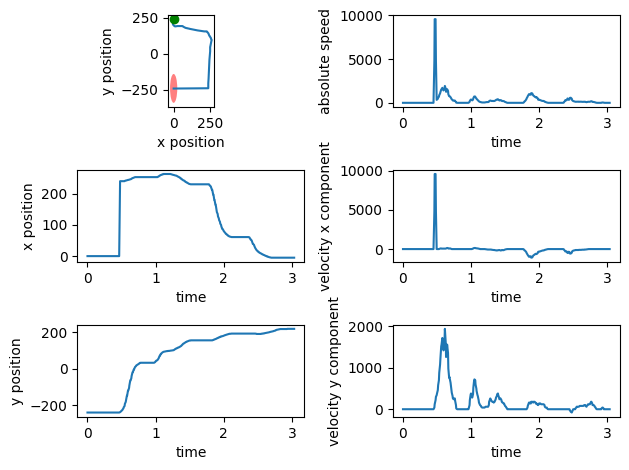

In [199]:
# plot the trajectory for this trial

fig, axs = plt.subplots(3,2)
#plot x-y trajectory
axs[0,0].plot(trial_data['cursor_x'],trial_data['cursor_y'])
axs[0,0].set_xlabel('x position')
axs[0,0].set_ylabel('y position')
axs[0,0].plot(trial_con.loc[0,'target_X'],trial_con.loc[0,'target_Y'],'go')
targetShape=ptch.Ellipse( trial_con.loc[0,['start_X','start_Y']],trial_con.loc[0,'cursor_SX'],trial_con.loc[0,'cursor_SY'], alpha=0.5,facecolor="red")
axs[0,0].add_patch(targetShape)
axs[0,0].set_aspect(1.0)
# plot x versus time
axs[1,0].plot(trial_data['time'],trial_data['cursor_x'])
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('x position')
# plot y versus time
axs[2,0].plot(trial_data['time'],trial_data['cursor_y'])
axs[2,0].set_xlabel('time')
axs[2,0].set_ylabel('y position')

# -----------------------
# plot velocity/speed
# -----------------------

axs[0,1].plot(trial_data['time'],trial_data['vabs'])
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('absolute speed')
# plot x versus time
axs[1,1].plot(trial_data['time'],trial_data['vx'])
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('velocity x component')
# plot y versus time
axs[2,1].plot(trial_data['time'],trial_data['vy'])
axs[2,1].set_xlabel('time')
axs[2,1].set_ylabel('velocity y component')

fig.tight_layout()

There are already a few things that you might want to have a look at in these profiles:
- Is the movement a straight line? (look at the top-left figure)
    - If not straight in which direction is it veering off?
    - Can you think of a reason that it might veer in that direction?
    => Biomechanische Ursachen, Visuelle Einflüsse und Motorisches Zögern
    
    - Compare with other trials. Is there any pattern you notice?
- From the absolute speed profile does this look like one smooth movement, or may there have been some sub-movements in this?
    - Can you think of ways that you might be able to tell one from the other?
- Comparing x and y components: do they start at the same time? (see also the first question)
- ...


### 3.2. Plotting conditions

After you read in all the trials for one participant, try comparing the effects of different conditions.

To get an intuition about comparing conditions, you can try the following:

* For all trials that have the target on the left, 
  * plot these trials paths and average paths 
  * and their velocity profiles and average velocity profiles

You can use above code to realize this. Hint: To take the average you first need to normalize time!

In [ ]:
# pruned_data = helpers.remove_outliers(trial_data_n, conditions=)
# TODO